In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Read in resonator data
df = pd.read_csv('IdealResonator.csv', sep=" ", skiprows=5)
df.head()

,!Freq,DBS11,AngS11,DBS21,AngS21,DBS12,AngS12,DBS22,AngS22,Unnamed: 9
0,4.000,-0.000362,-0.382208,-87.335502,-166.05402,-87.335502,-166.05402,-0.000362,-0.382208,NaN
1,4.002,-0.000362,-0.382399,-87.326395,-166.06518,-87.326395,-166.06518,-0.000362,-0.382399,NaN
2,4.004,-0.000362,-0.382590,-87.317292,-166.07632,-87.317292,-166.07632,-0.000362,-0.382590,NaN
3,4.006,-0.000363,-0.382781,-87.308195,-166.08746,-87.308195,-166.08746,-0.000363,-0.382781,NaN
4,4.008,-0.000363,-0.382972,-87.299102,-166.09859,-87.299102,-166.09859,-0.000363,-0.382972,NaN
...,...,...,...,...,...,...,...,...,...,...
7996,19.992,-0.008753,-1.888926,-59.528878,160.66579,-59.528878,160.66579,-0.008753,-1.888926,NaN
7997,19.994,-0.008755,-1.889111,-59.527254,160.66327,-59.527254,160.66327,-0.008755,-1.889111,NaN
7998,19.996,-0.008756,-1.889296,-59.525629,160.66076,-59.525629,160.66076,-0.008756,-1.889296,NaN
7999,19.998,-0.008758,-1.889481,-59.524005,160.65824,-59.524005,160.65824,-0.008758,-1.889481,NaN


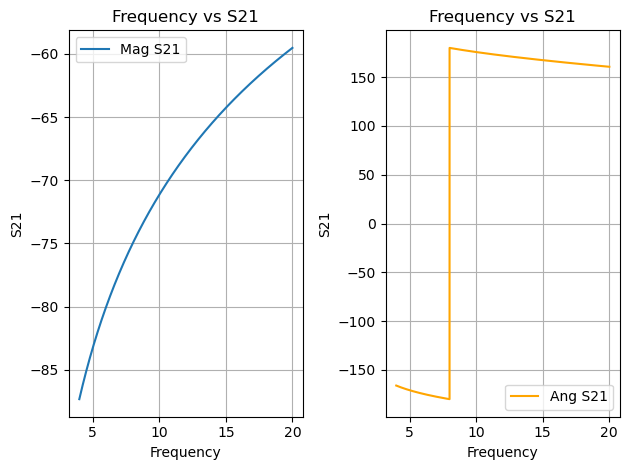

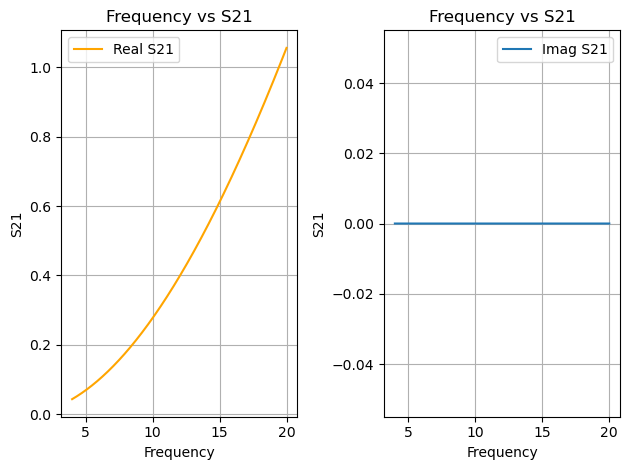

In [57]:
# Plot transmission data from dataframe
def plot_S21(df, magn=True, unwrap = False):
    # Plot frequency versus S21
    fig, (ax1, ax2) = plt.subplots(1, 2)

    if unwrap == True:
        freq = np.unwrap(df['!Freq'])
    else:
        freq = df['!Freq']

    if magn == True:
        ax1.plot(freq, df['DBS21'], label='Mag S21')
        ax2.plot(freq, df['AngS21'], color='orange', label='Ang S21')
    else:
        ampl = 1e3 * 10**(df['DBS21']/20)  # convert S21 dBm to linear
        real = np.real(ampl)
        imag = np.imag(ampl)        
        ax1.plot(freq, real, label='Real S21', color='orange')
        ax2.plot(freq, imag, label='Imag S21')

    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('S21')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('S21')
    ax1.set_title('Frequency vs S21')
    ax2.set_title('Frequency vs S21')
    ax1.legend()
    ax2.legend()
    ax1.grid(True)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


plot_S21(df)

plot_S21(df, magn=False)

In [11]:
# Add gaussian noise to transmission data
def add_gaussian_noise(df, mean=0, std=0.1, column='DBS21'):
    # Create a copy of the DataFrame to avoid modifying the original
    df_noisy = df.copy()
    # Add Gaussian noise to the specified column
    noise = np.random.normal(mean, std, len(df_noisy))
    df_noisy[column] += noise # + (1j * noise) # For if imaginary values

    return df_noisy

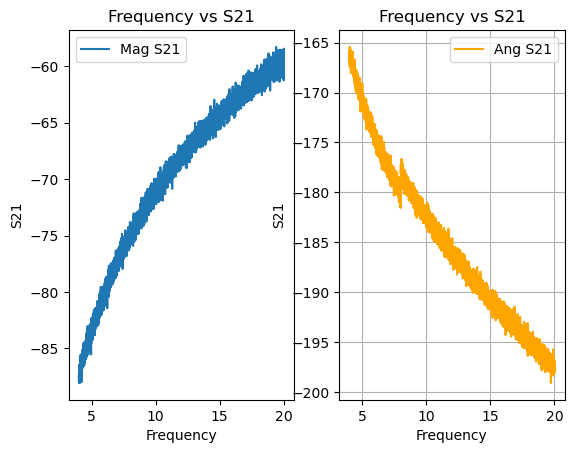

In [12]:
df_noisy = add_gaussian_noise(df, mean=0, std=0.5)
df_noisy = add_gaussian_noise(df_noisy, mean=0, std=0.5, column='AngS21')

plot_S21(df_noisy)

In [13]:
def add_pink_noise(df, exp=0.2, column='DBS21'):
    # Create a copy of the DataFrame to avoid modifying the original
    df_pink = df.copy()
    # Add Gaussian noise to the specified column
    pink_noise = np.random.randn(len(df_pink))
    # Scale the pink noise to have greater amplitude at lower frequencies
    pink_noise *= np.arange(1, len(df) + 1)**(-exp)
    df_pink[column] += pink_noise
    return df_pink

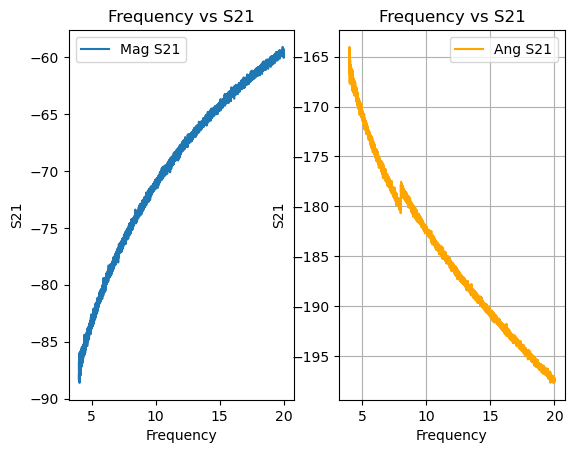

In [14]:
df_pink = add_pink_noise(df)
df_pink = add_pink_noise(df_pink, column='AngS21')

plot_S21(df_pink)

parameter names: ['f0', 'Q', 'Q_c']
independent variables: ['f']


c:\Anaconda\envs\bcqt\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


ValueError: x and y must have same first dimension, but have shapes (8001,) and (1,)

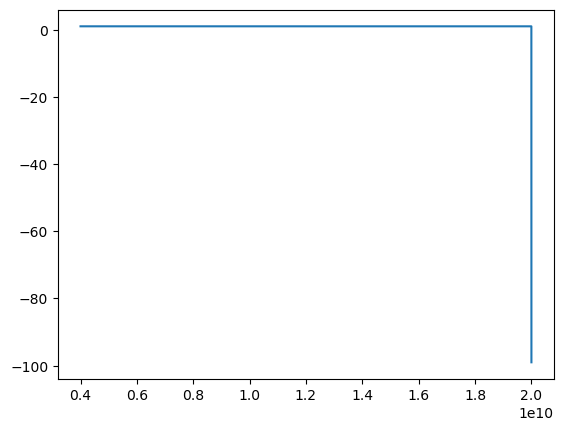

In [48]:
from lmfit import Model

def s21_hangarmode_real(f, f0, Q, Q_c):
    # equation to be modeled
    s21 = 1 - (Q/Q_c)/(1 + 2j*Q*(f/f0 - 1)) 

    return np.real(s21)

s21_model = Model(s21_hangarmode_real)

freq = df['!Freq']*1e9
resonance_idx = freq.argmax()
f0_guess = freq[resonance_idx]  # convert GHz to Hz
params = s21_model.make_params(f0=f0_guess, Q=1e6, Q_c=1e4)

result = s21_model.fit(freq, params, f=freq)


print(f'parameter names: {s21_model.param_names}')
print(f'independent variables: {s21_model.independent_vars}')

# before & after parameter fitting

plt.plot(freq, s21_model.eval(params, f=freq))
plt.plot(freq, result)
plt.yscale('log')











